In [1]:
import sys
import os
import json
import matplotlib.pyplot as plt
import numpy as np

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config

parent_path = os.path.dirname(os.getcwd())
target_dir = f'{parent_path}/lightcode'
sys.path.append(target_dir)

# import Relay_compiler
import graph_visualization as gv
import hardware as hw
import graph_transformations as gt
import stacked_graph as sg
import testing as test
import data_collection as dc
from main import forward


/home/rjtomich/miniconda3/envs/schedule/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import time
import cProfile
import pstats
import io

# Regular Inference (gpt2)

In [3]:
def generate_token(model_name, prompt):
    # model = AutoModelForCausalLM.from_pretrained(model_name, torchscript=True)
    # tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = GPT2LMHeadModel.from_pretrained("gpt2")
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

    tokenizer.pad_token = tokenizer.eos_token
    streamer = TextStreamer(tokenizer)

    model.tie_weights()

    inputs = tokenizer(prompt, return_tensors="pt", padding=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]



    model = model.eval()  # Change to eval mode

    # gen_tokens = model.generate(input_ids, do_sample=False, max_new_tokens=10, streamer=streamer)
    gen_tokens = model.generate(
                                    input_ids,
                                    attention_mask=attention_mask,
                                    do_sample=False,
                                    max_length=15,
                                    pad_token_id=tokenizer.pad_token_id,
                                    streamer=streamer
                                )

    gen_text = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)

    return input_ids, gen_tokens, gen_text
    return int(gen_tokens[0][-1])

model_name = 'gpt2'
prompt = "my favorite music is"

prompt_tokens, gen_tokens, gen_text = generate_token(model_name, prompt)
print(f'{"Prompt Tokens:":<20} {prompt_tokens}')
print(f'{"Generated Tokens:":<20} {gen_tokens}')

my favorite music is "The Last of Us" by the Grateful Dead.
Prompt Tokens:       tensor([[1820, 4004, 2647,  318]])
Generated Tokens:    tensor([[ 1820,  4004,  2647,   318,   366,   464,  4586,   286,  4021,     1,
           416,   262, 44249,  5542,    13]])


# Export the model to TVM Relay IR

Precomputed to save time (takes about 1 minuet for gpt2)

In [6]:
# model_onnx, input_ids = transformer_torch_to_onnx(model_name, prompt, save=False)
# lib = onnx_to_relay(model_onnx, input_ids, write=True, model_name=model_name, opt_level=0)

# Visualize computational Graph
Computational graph visualization for one token generation

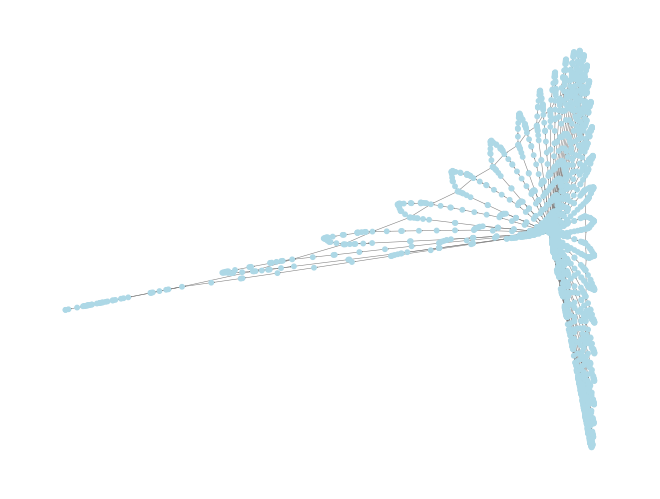

In [3]:
relay_path = "../lightcode/models/Llama-2-7b-hf_graph.json"

CPU_MAX_CLOCK = 5.0875 * 10**9
CPU_AVERAGE_CLOCK = 3.208 * 10**9
PHU_MIN_CLOCK = 10 * 10**9 #100**9, 10 Ghz

hardware = []
hw.Hardware._hardware_reset()
# hardware.append(hw.CPU(CPU_MAX_CLOCK, 1))
hardware.append(hw.CPU(CPU_AVERAGE_CLOCK, 1))
# hardware.append(hw.PHU(PHU_MIN_CLOCK, 1, 20))

available_hardware = hw.initilize_hardware(hardware)

optimization = 'time'
# optimization = 'energy'

with open(relay_path, encoding="utf-8") as json_file:
    raw_json = json.load(json_file)  # returns json file as dict

WEIGHT_VARIABLE = optimization
graph = sg.StackGraph(raw_json=raw_json, weight_variable=WEIGHT_VARIABLE)
gv.adj_to_graph(graph, ax=1, layout='spectral', title=f'Subgraph', stack=True)

# kk ,spectral, shell, spring


# Optimizations
1) Subdevide
2) Stack
3) select

# Create Simulation Enviroment

In [5]:
# relay_path = "../lightcode/models/Llama-2-7b-hf_graph.json" x
relay_path = "../lightcode/models/opt0_Llama-2-7b-hf_graph.json"

CPU_MAX_CLOCK = 5.0875 * 10**9
CPU_AVERAGE_CLOCK = 3.208 * 10**9
PHU_MIN_CLOCK = 10 * 10**9 #100**9, 10 Ghz

hardware = []
hw.Hardware._hardware_reset()
# hardware.append(hw.CPU(CPU_MAX_CLOCK, 1))
hardware.append(hw.CPU(CPU_AVERAGE_CLOCK, 1))
# hardware.append(hw.PHU(PHU_MIN_CLOCK, 1, 20))

available_hardware = hw.initilize_hardware(hardware)

optimization = 'time'
# optimization = 'energy'

In [19]:
def draw_subgraphs(subgraphs, stack = False):
    if isinstance(subgraphs, list):
        for g in subgraphs:
            fig, ax = plt.subplots(figsize=(5, 5))
            gv.adj_to_graph(g, ax=ax, stack=stack, layout='kk', title=f'Subgraph')
            # plt.tight_layout()
            plt.show()

    else:
        fig, ax = plt.subplots(figsize=(5, 5))
        gv.adj_to_graph(subgraphs, ax=ax, stack=stack, layout='kk', title=f'Subgraph')
        # plt.tight_layout()
        plt.show()


subgraph_to_plot = 3

with open(relay_path, encoding="utf-8") as json_file:
    raw_json = json.load(json_file)  # returns json file as dict

WEIGHT_VARIABLE = optimization
time_s = time.time()
graph = sg.StackGraph(raw_json=raw_json, weight_variable=WEIGHT_VARIABLE)
print('graph')
stacked_subgraphs = list(gt.graph_partition(graph, weight_variable=WEIGHT_VARIABLE))
# print(f'stacked_subgraphs: {len(stacked_subgraphs)}')

flat_subgraphs = gt.select_nodes(
    stacked_subgraphs, weight_variable=WEIGHT_VARIABLE
)
time_e = time.time()
print(f'time: {time_e - time_s}')

# print('flat_subgraphs')
# expanded_flat_subgraphs = gt.expand_nodes(flat_subgraphs)

# phu = 0
# cpu = 0
# phu_algs = set()
# for g in flat_subgraphs:
#     for node in g.node_list:
#         if node.algorithm in ['task_para_matmul_phu', 'task_para_dense_phu']:
#             phu += 1
#             phu_algs.add(node.algorithm)
#         if node.algorithm in ['dense', 'matmul']:
#             cpu += 1

# print (f'{phu} / {cpu}')
# print(phu_algs)


# print(f' 2 / {len(stacked_subgraphs)}')
# draw_subgraphs(flat_subgraphs, stack = False)

graph
stacked_subgraphs: 66
67
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
55
21
7
5
time: 5.121786594390869
flat_subgraphs


In [12]:
# profiling
pr = cProfile.Profile()
pr.enable()
flat_subgraphs = gt.select_nodes(
    stacked_subgraphs[:48], weight_variable=WEIGHT_VARIABLE
)
pr.disable()

# Print the profiling results
s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
ps.print_stats()
# print(s.getvalue())


# MAC's in GP2 Inference

In [8]:
scheduled_flat_graph, end_time, break_points = gt.schdeule_nodes(
    graph, expanded_flat_subgraphs, available_hardware
)
time_profile = dc.get_time_profile(scheduled_flat_graph)
energy_profile = dc.get_energy_per_opp(scheduled_flat_graph)
print(time_profile)
print(energy_profile)

{'where': 6.234413965087282e-10, 'multiply': 0.0037844588528678485, 'nop': 2.0105985037406406e-07, 'dense': 2.713983896946744, 'matmul': 0.0006988929252715189, 'add': 0.00022814972181801457, 'to': 1.1221945137157107e-08, 'slice': 4.9875311720698114e-08, 'negative': 0.0002451471321695763, 'transpose': 0.0017160299251870277, 'equal': 1.1221945137157107e-08, 'take': 3.117206982543641e-10, 'nd': 1.1221945137157107e-08, 'mean': 0.000498076683291771, 'rsqrt': 1.215710723192021e-07, 'concatenate': 1.995012468827929e-08, 'less': 3.117206982543641e-10, 'softmax': 6.894763092269324e-05, 'cast': 1.870324189526185e-09, 'power': 0.0004979551122194518, 'sigmoid': 0.002635331670822943, 'get_dram': 0.0}
{'where': 2e-12, 'multiply': 3.85999999999999e-10, 'nop': 6.449999999999981e-10, 'dense': 0.0039642464256000095, 'matmul': 9.437183999999994e-07, 'add': 2.269999999999995e-10, 'to': 1e-12, 'slice': 1.5999999999999973e-10, 'negative': 6.400000000000006e-11, 'transpose': 2.239999999999995e-10, 'equal': 1

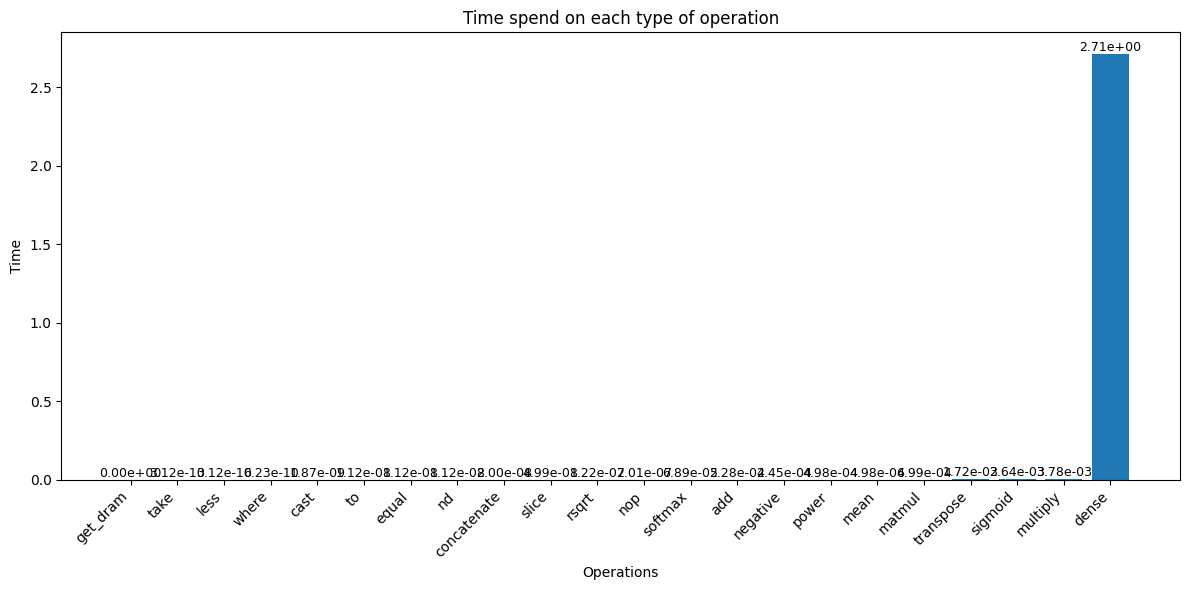

In [9]:
time_profile_sorted = dict(sorted(time_profile.items(), key=lambda item: item[1]))
energy_profile_sorted = dict(sorted(energy_profile.items(), key=lambda item: item[1]))


labels = list(time_profile_sorted.keys())
values = list(time_profile_sorted.values())

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(labels, values)

ax.set_xlabel('Operations')
ax.set_ylabel('Time')
ax.set_title('Time spend on each type of operation')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2e}', va='bottom', ha='center', fontsize=9)

# Show plot
plt.tight_layout()
plt.show()


# End to End

In [11]:
# relay_path = "../lightcode/models/Llama-2-7b-hf_graph.json"
relay_path = "../lightcode/models/opt0_Llama-2-7b-hf_graph.json"


CPU_MAX_CLOCK = 5.0875 * 10**9
CPU_AVERAGE_CLOCK = 3.208 * 10**9
PHU_MIN_CLOCK = 10 * 10**9 #100**9, 10 Ghz

hardware = []
hw.Hardware._hardware_reset()
hardware.append(hw.CPU(CPU_MAX_CLOCK, 1))
# hardware.append(hw.CPU(CPU_AVERAGE_CLOCK, 1))
# hardware.append(hw.PHU(PHU_MIN_CLOCK, 1, 20))

available_hardware = hw.initilize_hardware(hardware)

optimization = 'time'
# optimization = 'energy'

forward(
    relay_path,
    optimization,
    available_hardware,
    profiles=True,
    get_step_times=False,
    data_collection=False,
)


KeyboardInterrupt: 